In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [ ]:
!pip install torch==1.5.0  torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html



Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 30kB/s 
     |████████████████████████████████| 6.5MB 61.9MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import torchvision
from torchsummary import summary
from myfunctions import *
from models import *
from Grad_Cam import get_last_conv,Grad_Cam
from transforms_dataloading import downloading_data_transforms_albumentations
from tqdm import tqdm

from albumentations import  ( 
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose , Normalize ,ToFloat, Cutout
)

import cv2

import numpy as np

# from albumentations.pytorch import  ToTensor 

In [ ]:
print(torch. __version__)
print(torchvision. __version__)

1.5.0+cu92
0.6.0+cu92


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks/EVA_P2/S2/Session 2 Dataset'

/content/drive/.shortcut-targets-by-id/1gsDgSBaoqrM6-W1b9HXuMRZc9SzwM98d/Session 2 Dataset


In [ ]:
!ls '/content/drive/My Drive/Colab Notebooks/EVA_P2/S2'

'Session 2 Dataset'  'Session 2 Dataset (1)'


In [ ]:
%matplotlib inline

**Downloading datasets and applying transforms**

In [ ]:
dataset= datasets.ImageFolder(root="/content/drive/.shortcut-targets-by-id/1gsDgSBaoqrM6-W1b9HXuMRZc9SzwM98d/Session 2 Dataset")



In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 16996
    Root location: /content/drive/.shortcut-targets-by-id/1gsDgSBaoqrM6-W1b9HXuMRZc9SzwM98d/Session 2 Dataset

In [ ]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 16996
    Root location: /content/drive/.shortcut-targets-by-id/1gsDgSBaoqrM6-W1b9HXuMRZc9SzwM98d/Session 2 Dataset

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [12000, 4996])

In [ ]:
transform_train = transforms.Compose(
[transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transform_test = transforms.Compose(
[transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [ ]:
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map :     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  # image
        y = self.dataset[index][1]   # label      
        return x, y

    def __len__(self):
        return len(self.dataset)


        # if self.map:     
        #       x = self.map(self.dataset[index][0]) 
        #   else:     
        #       x = self.dataset[index][0]  # image
        #   y = self.dataset[index][1]   # label   

In [ ]:
trainset = MapDataset(train_set, transform_train)

testset = MapDataset(test_set, transform_test)

**Loading data to train and test loader**

In [ ]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(111)

if cuda:
    torch.cuda.manual_seed(111)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True,num_workers=4)
    testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True, num_workers=4)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

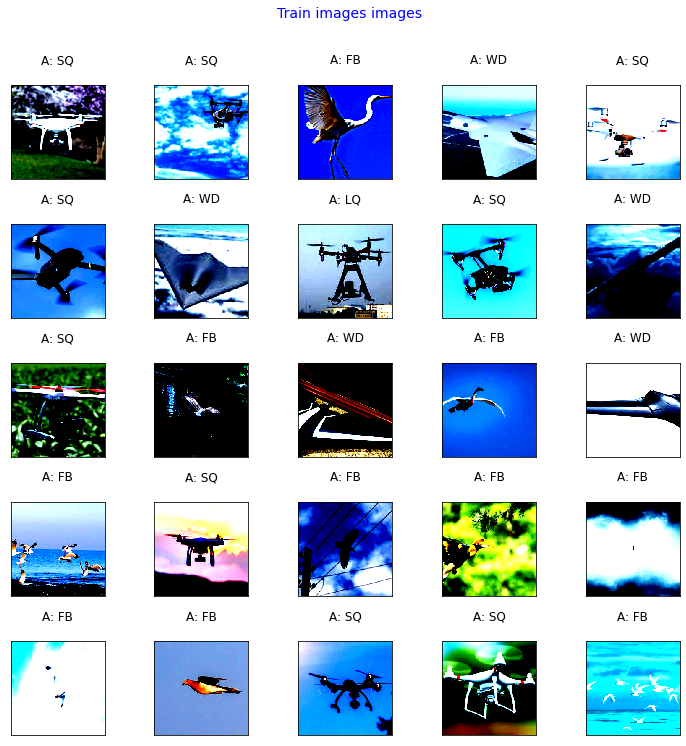

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import PIL.Image as Image

classes = ('FB', 'LQ', 'SQ','WD')


fig = plt.figure()
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Train images images' ,y=1.05,fontsize=14,color='b')

dataiter = iter(trainloader)
images, labels = dataiter.next()

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(((images[i]).permute(1,2,0).numpy().squeeze()), interpolation='none')
  plt.title('A: {}\n'.format(classes[labels[i]]))

  plt.xticks([])
  plt.yticks([])


**Building model network**

In [ ]:
from torchvision import models
Net= models.mobilenet_v2(pretrained=True)

# for child in Net.children():
#   print(child)

# print(model.classifier)

for i, param in enumerate(Net.parameters()):
    param.requires_grad = False
    # print(i, param.requires_grad)

Net.classifier[1] = torch.nn.Linear(in_features=Net.classifier[1].in_features, out_features=4)
print(Net.classifier)


for i, param in enumerate(Net.parameters()):
    # param.requires_grad = False
    print(i, param.requires_grad)


print(Net.classifier)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth



Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)
0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False

**Adding model to device**

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net.to(device)
summary(model,input_size=(3,224,224))
print("Model added to device")

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1

**LR Finder**

In [ ]:
def training_model_with_scheduler(model, device, train_loader, optimizer,criterion):

  import torch
  import torch.nn as nn
  import torch.nn.functional as F
  import torch.optim as optim
  from torchvision import datasets, transforms
  import torchvision
  from torchsummary import summary
  from tqdm import tqdm

  model.train()
  pbar=tqdm(train_loader)
  train_losses=[]
  train_acces=[]

  correct = 0
  processed = 0
  train_loss=0
  running_loss=0
  lr_step=0

  L2lambda=0
  for data,target in train_loader:
    data, target = data.to(device), target.to(device)
    
    
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    
    running_loss += loss.item()

    # Backpropagation
    loss.backward()
    

    # lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    # scheduler.step()
    # Update pbar-tqdm
    optimizer.step()
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    acc=100*(correct/processed)

    

  running_loss /=len(data)
  train_losses.append(running_loss)
  train_acces.append(acc)
  
  # scheduler.step(running_loss)
  # print("LR used in this epoch is:",lr_step)
  print('\nTrain set: Average loss: {:.4f}, Train Accuracy: ({:.2f}%)\n'.format(running_loss,acc))  
  return train_losses,train_acces



In [ ]:


criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model.parameters(), lr=0.001, nesterov=True, momentum=0.9,weight_decay=0)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:


def testing_model(model, device, testloader):
    model.eval()
    test_loss = 0
    correct = 0
    test_losses=[]
    test_acces=[]
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
      for datax in testloader:
          data ,target =datax
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += criterion(output, target).item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /=len(data)
    test_losses.append(test_loss)
    test_acc=(100. * correct / len(testloader.dataset))
    test_acces.append(test_acc)
    print('\nTest set: Average Loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),test_acc))
    return test_losses,test_acces

**Defining optimizer and Training model**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import torch.optim as optim
train_los=[]
train_acs=[]
test_los=[]
test_acs=[]

EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses,train_acces=training_model_with_scheduler(model, device, trainloader, optimizer,criterion)
    train_los.append(train_losses)
    train_acs.append(train_acces)
    test_losses, test_acces=testing_model(model, device, testloader)
    test_los.append(test_losses)
    test_acs.append(test_acces)


  0%|          | 0/24 [00:00<?, ?it/s]

EPOCH: 0

Train set: Average loss: 0.0612, Train Accuracy: (83.62%)





  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average Loss: 0.0770, Test Accuracy: 4245/4996 (84.97%)

EPOCH: 1

Train set: Average loss: 0.0501, Train Accuracy: (85.99%)






  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average Loss: 0.0675, Test Accuracy: 4286/4996 (85.79%)

EPOCH: 2

Train set: Average loss: 0.0447, Train Accuracy: (86.98%)







  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average Loss: 0.0622, Test Accuracy: 4305/4996 (86.17%)

EPOCH: 3

Train set: Average loss: 0.0415, Train Accuracy: (87.11%)








  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average Loss: 0.0589, Test Accuracy: 4322/4996 (86.51%)

EPOCH: 4

Train set: Average loss: 0.0392, Train Accuracy: (87.93%)









  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average Loss: 0.0561, Test Accuracy: 4343/4996 (86.93%)

EPOCH: 5

Train set: Average loss: 0.0377, Train Accuracy: (88.11%)










  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average Loss: 0.0540, Test Accuracy: 4371/4996 (87.49%)

EPOCH: 6

Train set: Average loss: 0.0366, Train Accuracy: (88.38%)











  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average Loss: 0.0530, Test Accuracy: 4387/4996 (87.81%)

EPOCH: 7

Train set: Average loss: 0.0357, Train Accuracy: (88.73%)












  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average Loss: 0.0517, Test Accuracy: 4409/4996 (88.25%)

EPOCH: 8

Train set: Average loss: 0.0345, Train Accuracy: (88.96%)













  0%|          | 0/24 [00:00<?, ?it/s]


Test set: Average Loss: 0.0505, Test Accuracy: 4410/4996 (88.27%)

EPOCH: 9

Train set: Average loss: 0.0338, Train Accuracy: (89.18%)


Test set: Average Loss: 0.0497, Test Accuracy: 4437/4996 (88.81%)



In [ ]:
model.to('cpu')
model.eval()

traced_model =torch.jit.trace(model,torch.randn(1,3,224,224))
torch.jit.save(traced_model,'EVA_P2/S2/mobilenetv2-custom-c4.pt')



**Loss and Accuracy graphs**

In [ ]:
import pandas as pd
tr_lo_df=pd.DataFrame(train_los,columns=['Loss'])
ts_lo_df=pd.DataFrame(test_los,columns=['Loss'])
tr_ac_df=pd.DataFrame(train_acs,columns=['acc'])
ts_ac_df=pd.DataFrame(test_acs,columns=['acc'])

Text(0.5, 1.0, 'Train Test Accuracy')

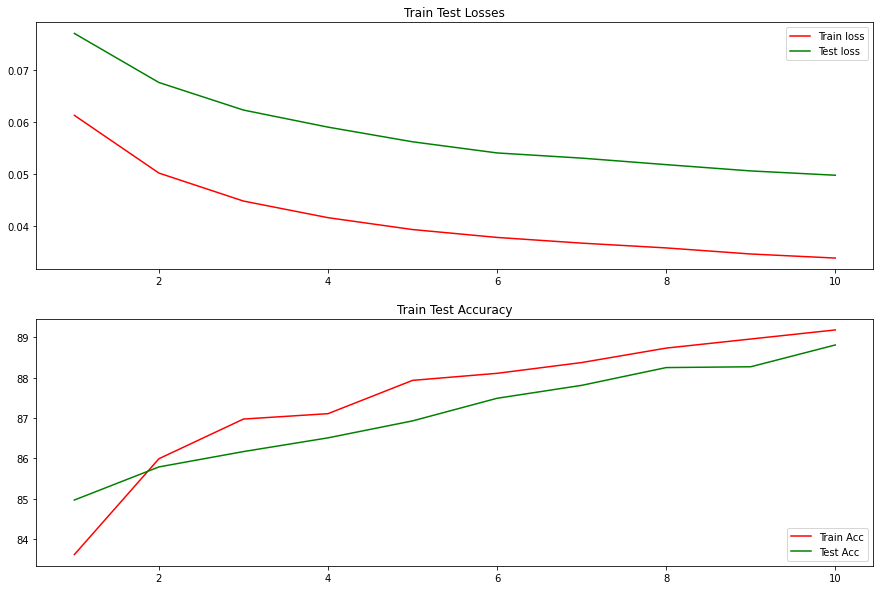

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,1,figsize=(15,10))
axs[0].plot(tr_lo_df.index+1,tr_lo_df['Loss'],color='red')
axs[0].plot(ts_lo_df.index+1,ts_lo_df['Loss'],color='green')

axs[0].legend(['Train loss','Test loss'], loc='upper right')
axs[0].set_title("Train Test Losses")
# axs[0].set_ylim([-100,800])


axs[1].plot(tr_ac_df.index+1,tr_ac_df['acc'],color='red')
axs[1].plot(ts_ac_df.index+1,ts_ac_df['acc'],color='green')

axs[1].legend(['Train Acc','Test Acc'], loc='lower right')
axs[1].set_title("Train Test Accuracy")

**Miss classified Images**

In [ ]:
model.to(device)
incorrect_images,incorrect_images_label,incorrect_images_predl=get_miss_classified_images(model,device,testloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

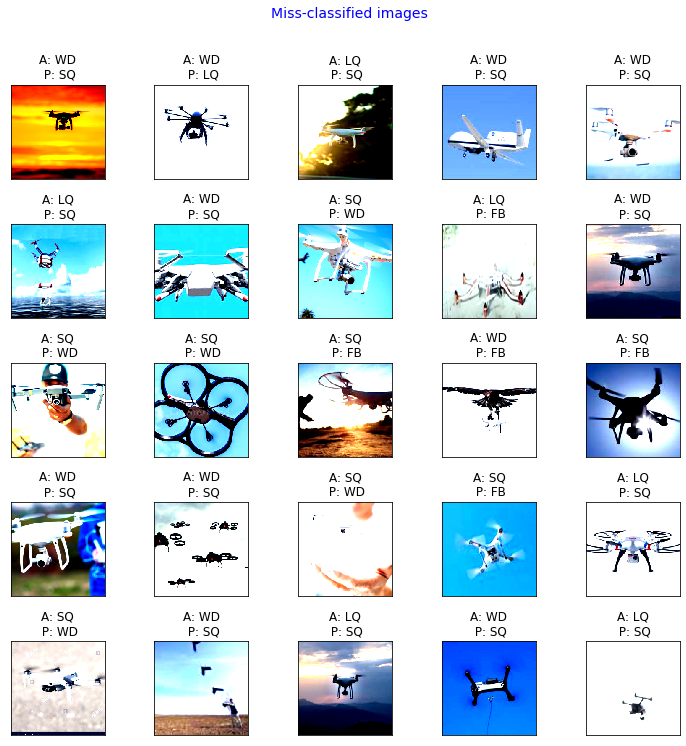

In [ ]:
imgs=torch.Tensor.cpu(incorrect_images)
import matplotlib.pyplot as plt


classes = ('FB', 'LQ', 'SQ','WD')

fig = plt.figure()
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Miss-classified images' ,y=1.05,fontsize=14,color='b')
for i in range(25):

  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(((((imgs[i]/2)+0.5)*255).permute(1, 2, 0).numpy()).astype(int), interpolation='none')
  plt.title('A: {}\n P: {}'.format( classes[incorrect_images_label[i]],classes[incorrect_images_predl[i]]))

  plt.xticks([])
  plt.yticks([])

imgs25=imgs[0:25]
incorrect_images25_label=incorrect_images_label[0:25]
incorrect_images25_predl=incorrect_images_predl[0:25]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

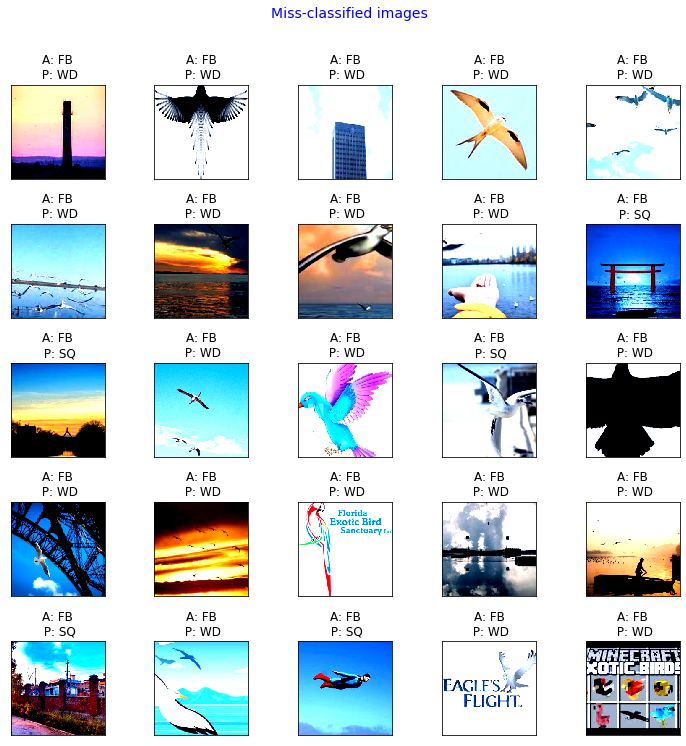

In [ ]:
imgs=torch.Tensor.cpu(incorrect_images)
import matplotlib.pyplot as plt

ind=[]
classes = ('FB', 'LQ', 'SQ','WD')
j=0
fig = plt.figure()
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Miss-classified images' ,y=1.05,fontsize=14,color='b')
for i in range(0, len(incorrect_images_label)):
  if incorrect_images_label[i]==0 and j <25:
      j+=1
      ind.append(i)
for k,i in enumerate(ind):

  plt.subplot(5,5,k+1)
  plt.tight_layout()
  plt.imshow(((((imgs[i]/2)+0.5)*255).permute(1, 2, 0).numpy()).astype(int), interpolation='none')
  plt.title('A: {}\n P: {}'.format( classes[incorrect_images_label[i]],classes[incorrect_images_predl[i]]))

  plt.xticks([])
  plt.yticks([])

# imgs25=imgs[0:25]
# incorrect_images25_label=incorrect_images_label[0:25]
# incorrect_images25_predl=incorrect_images_predl[0:25]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

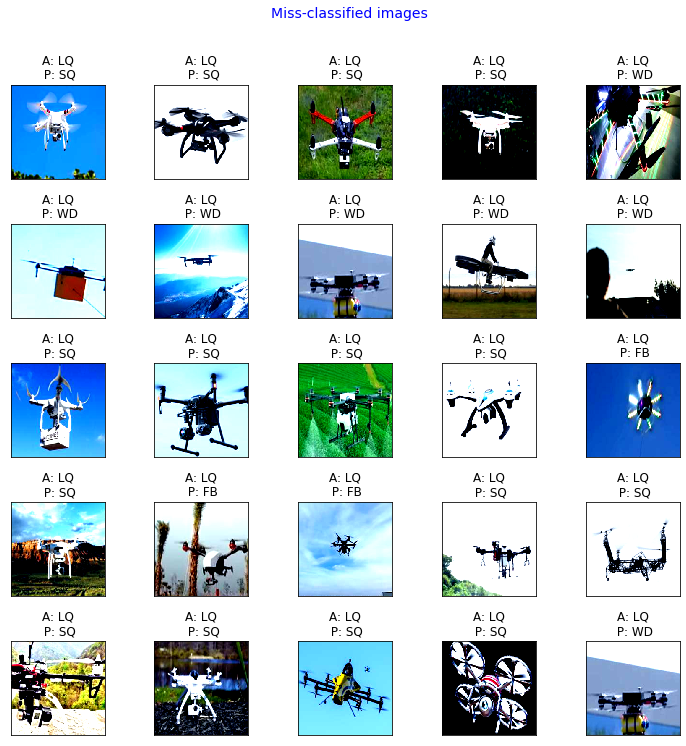

In [ ]:
imgs=torch.Tensor.cpu(incorrect_images)
import matplotlib.pyplot as plt

ind=[]
classes = ('FB', 'LQ', 'SQ','WD')
j=0
fig = plt.figure()
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Miss-classified images' ,y=1.05,fontsize=14,color='b')
for i in range(0, len(incorrect_images_label)):
  if incorrect_images_label[i]==1 and j <25:
      j+=1
      ind.append(i)
for k,i in enumerate(ind):

  plt.subplot(5,5,k+1)
  plt.tight_layout()
  plt.imshow(((((imgs[i]/2)+0.5)*255).permute(1, 2, 0).numpy()).astype(int), interpolation='none')
  plt.title('A: {}\n P: {}'.format( classes[incorrect_images_label[i]],classes[incorrect_images_predl[i]]))

  plt.xticks([])
  plt.yticks([])
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

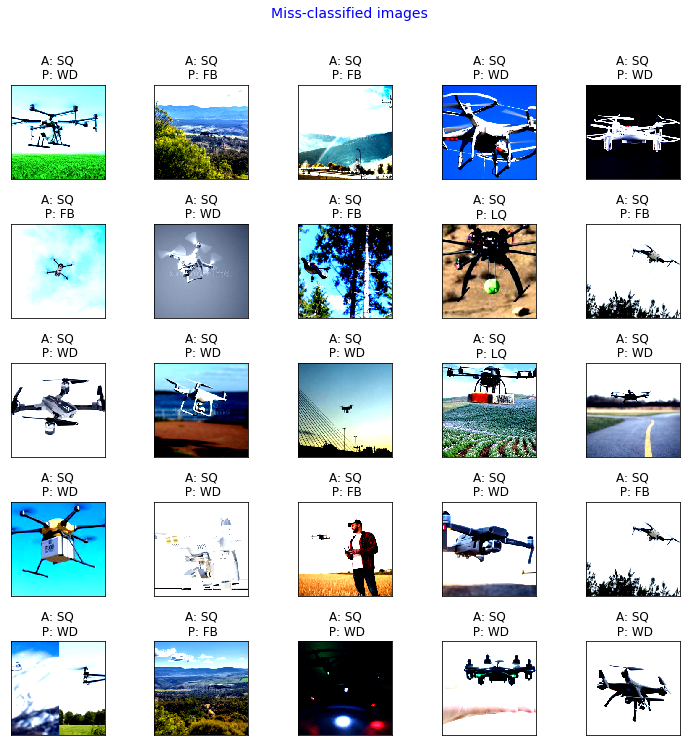

In [ ]:
imgs=torch.Tensor.cpu(incorrect_images)
import matplotlib.pyplot as plt

ind=[]
classes = ('FB', 'LQ', 'SQ','WD')
j=0
fig = plt.figure()
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Miss-classified images' ,y=1.05,fontsize=14,color='b')
for i in range(0, len(incorrect_images_label)):
  if incorrect_images_label[i]==2 and j <25:
      j+=1
      ind.append(i)
for k,i in enumerate(ind):

  plt.subplot(5,5,k+1)
  plt.tight_layout()
  plt.imshow(((((imgs[i]/2)+0.5)*255).permute(1, 2, 0).numpy()).astype(int), interpolation='none')
  plt.title('A: {}\n P: {}'.format( classes[incorrect_images_label[i]],classes[incorrect_images_predl[i]]))

  plt.xticks([])
  plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

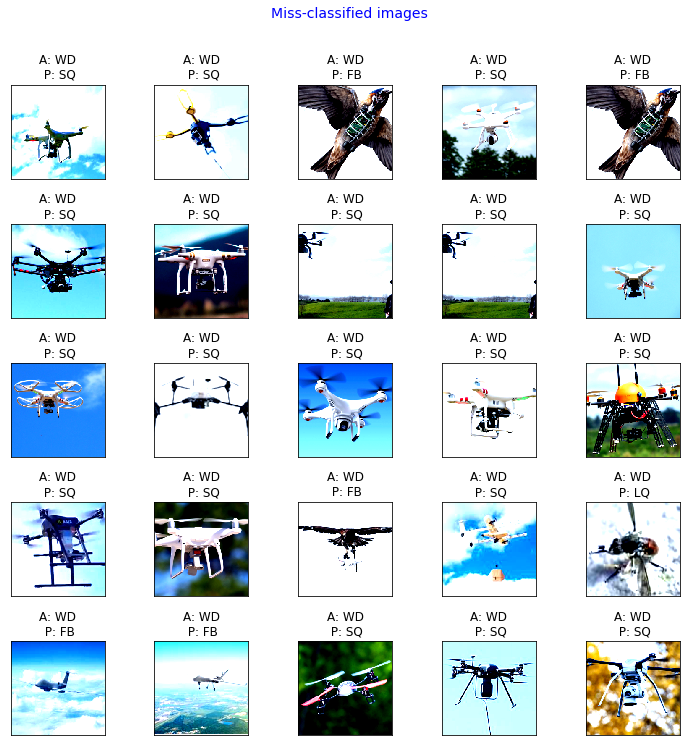

In [ ]:
imgs=torch.Tensor.cpu(incorrect_images)
import matplotlib.pyplot as plt

ind=[]
classes = ('FB', 'LQ', 'SQ','WD')
j=0
fig = plt.figure()
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Miss-classified images' ,y=1.05,fontsize=14,color='b')
for i in range(0, len(incorrect_images_label)):
  if incorrect_images_label[i]==3 and j <25:
      j+=1
      ind.append(i)
for k,i in enumerate(ind):

  plt.subplot(5,5,k+1)
  plt.tight_layout()
  plt.imshow(((((imgs[i]/2)+0.5)*255).permute(1, 2, 0).numpy()).astype(int), interpolation='none')
  plt.title('A: {}\n P: {}'.format( classes[incorrect_images_label[i]],classes[incorrect_images_predl[i]]))

  plt.xticks([])
  plt.yticks([])

**Plotting GradCam Images **

<Figure size 432x288 with 0 Axes>

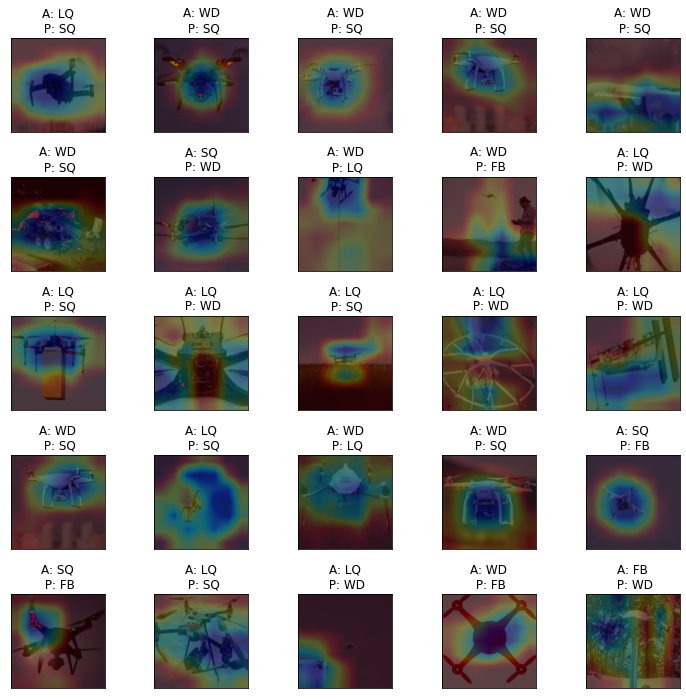

In [ ]:
	
if __name__ == '__main__':
    use_cuda = torch.cuda.is_available()
    fig = plt.figure()
    fig = plt.figure(figsize=(10, 10))
    for i,imgn in enumerate(imgs25):
      model.eval()
      
      imgn=((imgn*0.25)+0.5)
      # imgn=(imgn*255)
      # print(imgn)
      img=imgn.permute(1, 2, 0).numpy()
      #getting last conv layer
      m = get_last_conv(model)
      target_layer = [m]
      Grad_cams = Grad_Cam(model,target_layer,use_cuda)
      grad_cam_list  = Grad_cams(img)
      #target_layer corresponding grad_cam_list
      superimposed_img = (img + grad_cam_list[0] *0.5 ).astype(int)


      plt.subplot(5,5,i+1)
      plt.tight_layout()
  
      plt.imshow(superimposed_img)
      plt.title('A: {}\n P: {}'.format( classes[incorrect_images25_label[i]],classes[incorrect_images25_predl[i]]))

      plt.xticks([])
      plt.yticks([])
